In [51]:
%%timeit -n1 -r1
!python create_mmap_script.py /storage/data/special/jp2cache/B_37_FB3-SL_570-ST_NISL-SE_1708_lossless.jp2 /storage/data/special/jp2cache

glymur not setup correctly
starting kdu_expand B_37_FB3-SL_570-ST_NISL-SE_1708_lossless.jp2

Consumed 1679360 tile-part(s) from a total of 26,240 tile(s).
Consumed 13,014,679,774 codestream bytes (excluding any file format) =
15.266245 bits/pel.
Processed using the multi-threaded environment, with
    16 parallel threads of execution
expand time: 0:02:39.560841
{'imgpath': '/storage/data/special/jp2cache/B_37_FB3-SL_570-ST_NISL-SE_1708_lossless.tif', 'imageshape': (83590, 81590, 3), 'tileshape': (4096, 4096, 3), 'padding': 0, 'ntiles': 400}
load time: 0:00:12.234098
flush time: 0:00:05.130257
3min 16s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [155]:
!ls /storage/data/special/jp2cache/*_1708*

/storage/data/special/jp2cache/B_37_FB3-SL_570-ST_NISL-SE_1708_lossless.dat
/storage/data/special/jp2cache/B_37_FB3-SL_570-ST_NISL-SE_1708_lossless.jp2
/storage/data/special/jp2cache/B_37_FB3-SL_570-ST_NISL-SE_1708_lossless_info.pkl


In [52]:
import pickle
from tempfile import TemporaryDirectory
import subprocess
from PIL import Image

def kdu_expand_rgn(jp2path,rgn):
    im = None
    with TemporaryDirectory(dir='.') as tmpdir:
        tmpoutname = '%s/tile.tif' % tmpdir
        x,y,w,h = rgn
        cmd = 'LD_LIBRARY_PATH=./lib ./kdu_expand -i %s -o %s -region "{%.4f,%.4f},{%.4f,%.4f}" -quiet' % (jp2path, tmpoutname, y,x,h,w)
#         print(cmd)
        ret = subprocess.call(cmd, shell=True)
        if ret==0:
            im = Image.open(tmpoutname)
    return im

import pickle

class TileIterator:
    def __init__(self, jp2path, tilesize=512):
        self.jp2path = jp2path
        infofile = jp2path.replace('.jp2','_info.pkl')
        info = pickle.load(open(infofile,'rb'))
        self.shape = info['shape'] # nr,nc
        self.tileshape = (tilesize,tilesize) # nr,nc
        self.ntiles_c = round(self.shape[1]/tilesize) # FIXME: was ceil, changing to round for compat with ui
        self.ntiles_r = round(self.shape[0]/tilesize) # not actually used anywhere - only print
        self.ntiles = self.ntiles_r * self.ntiles_c
        self.i = -1

    
    def get_rgn(self,tilenum,relative=True):
        assert tilenum < self.ntiles
        
        tile_r = tilenum//self.ntiles_c
        tile_c = tilenum % self.ntiles_c
        x = self.tileshape[1]*tile_c
        y = self.tileshape[0]*tile_r
        w = min(self.shape[1]-x,self.tileshape[1])
        h = min(self.shape[0]-y,self.tileshape[0])
        if relative:
            return x/self.shape[1], y/self.shape[0], w/self.shape[1],h/self.shape[0]
        else:
            return x,y, w,h
    
    def __iter__(self):
        self.i = -1
        return self
    
    def __next__(self):
        if self.i < self.ntiles:
            self.i+=1
            return self.get_rgn(self.i)
        else:
            raise StopIteration()

    

In [159]:
kduiter = TileIterator('/storage/data/special/jp2cache/B_37_FB3-SL_570-ST_NISL-SE_1708_lossless.jp2',512)

In [160]:
kduiter.ntiles

25917

In [161]:
kduiter.get_rgn(2440,relative=False)

(28160, 7680, 512, 512)

In [152]:
im=kdu_expand_rgn(kduiter.jp2path,kduiter.get_rgn(2440))

In [153]:
from matplotlib import pyplot as plt

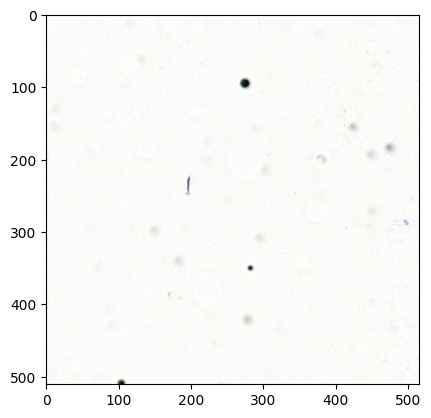

In [154]:
plt.imshow(im)

In [157]:
import numpy as np
datfile = kduiter.jp2path.replace('.jp2','.dat')
mm = np.memmap(datfile,shape=kduiter.shape,dtype=np.uint8)

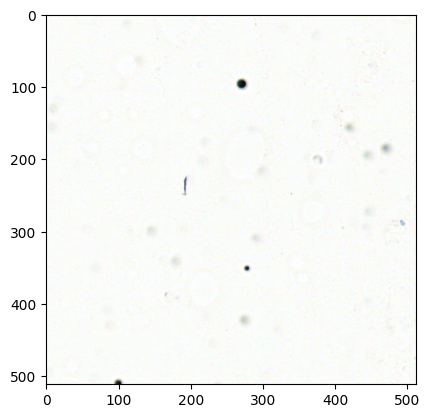

In [158]:
x,y,w,h=kduiter.get_rgn(2440,relative=False)
plt.imshow(mm[y:y+h,x:x+w])

naive

In [162]:
%%timeit -n1 -r1
for ii,rgn in enumerate(kduiter):
    im = kdu_expand_rgn(kduiter.jp2path,rgn)
    if ii > 20: #kduiter.ntiles//100:
        break


18.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [163]:
from utils_multiproc import get_multiproc_plan
from functools import partial
from concurrent.futures import ProcessPoolExecutor

plan = get_multiproc_plan(kduiter.ntiles//10,minwork=20)
print(plan)

def workerfunc(tilenum):
    rgn = kduiter.get_rgn(tilenum)
    return tilenum, kdu_expand_rgn(kduiter.jp2path,rgn)



MultiprocPlan(worksize=2591, nworkers=128, perworker=20, rounds=1, minwork=20)


threaded

In [164]:
%%timeit -n1 -r1
nworkers = 4 #plan.nworkers
with ProcessPoolExecutor(max_workers=nworkers) as executor:
    for tilenum,im in executor.map(workerfunc,range(20)):
        pass

4.61 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
